In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.spatial import Voronoi
from tyssue import Epithelium

from tyssue.core.generation import from_2d_voronoi
from tyssue import config
from tyssue.draw.threejs_draw import view_3js
from tyssue import SheetGeometry
from tyssue.core.objects import get_opposite
from tyssue.draw.plt_draw import quick_edge_draw  

from tyssue.draw.threejs_draw import edge_lines
import pythreejs as py3js

import seaborn as sns

import matplotlib as mpl

In [2]:
a, b, c = 170, 170, 250
epsilon = 1e-6

n_zs = 31
dist = c / (1.76*n_zs)
zs = np.linspace(-c+dist/2, c-dist/2, n_zs)

thetas = np.arcsin(zs/c)
av_rhos = (a + b) * np.cos(thetas) / 2
n_cells = np.ceil(av_rhos/dist).astype(np.int)

phis = np.concatenate(
    [np.linspace(-np.pi, np.pi, nc, endpoint=False)
     + (np.pi/nc) * (i%2) for i, nc in enumerate(n_cells)])
zs = np.concatenate(
    [z * np.ones(nc) for z, nc in zip(zs, n_cells)])
thetas = np.concatenate(
    [theta * np.ones(nc) for theta, nc in zip(thetas, n_cells)])

xs = a * np.cos(thetas) * np.cos(phis) + np.random.normal(scale=epsilon,
                                                          size=thetas.shape)
ys = b * np.cos(thetas) * np.sin(phis) + np.random.normal(scale=epsilon,
                                                          size=thetas.shape)
zs +=  np.random.normal(scale=epsilon, size=thetas.shape)
print(zs.shape)


(902,)


In [3]:
centers = pd.DataFrame.from_dict({'x': xs, 'y': ys, 'z': zs,
                                  'theta': thetas, 'phi': phis})

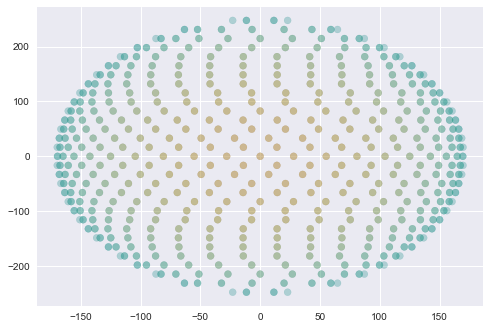

In [8]:
fig, ax = plt.subplots()
ax.scatter(centers.x, centers.z, 
           c=centers.y, cmap='viridis', alpha=0.3)

In [22]:
def local_voro(centers, radius, face,
               coords=['x', 'y', 'z']):
    
    neighbs = centers[coords].copy()
    for c in coords:
        neighbs[c] -= neighbs.loc[face, c]
    
    rel_dist = np.linalg.norm(neighbs, axis=1)
    
    neighbs = neighbs[rel_dist < 2*radius]
    U, s, V = np.linalg.svd(neighbs.values,
                            full_matrices=False,
                            compute_uv=True)
    rotated = np.dot(neighbs.values, V.T)
    f_ids = neighbs.index
    # voro = Voronoi(rotated[:, [0, 1]])
    dsets = from_2d_voronoi(Voronoi(rotated[:, [0, 1]]))
    dsets['face']['z'] = rotated[:, 2]
    dsets['face']['id'] = f_ids.values
    eptm = Epithelium('loc', dsets, config.geometry.flat_sheet())
    eptm.edge_df['face_z'] = eptm.upcast_face(
        eptm.face_df['z'])
    eptm.edge_df['face_id'] = eptm.upcast_face(
        eptm.face_df['id'])
    eptm.vert_df['z'] = eptm.edge_df.groupby('srce')['face_z'].mean()
    eptm.vert_df[['x', 'y', 'z']] = np.dot(eptm.vert_df[['x', 'y', 'z']].values, V)

    for c in coords:
        eptm.vert_df[c] += centers.loc[face, c]
    eptm.sanitize()
    eptm.reset_index()
    eptm.edge_df['opposite'] = get_opposite(eptm.edge_df)
    eptm.edge_df['opp_face_id'] = data_at_opposite(eptm, eptm.edge_df['face_id'])
    free = eptm.edge_df[eptm.edge_df['opposite']<0].index
    eptm.remove(free)
    SheetGeometry.update_all(eptm)
    return eptm
    

In [10]:
%pdb

Automatic pdb calling has been turned OFF


In [23]:
from tyssue.utils import data_at_opposite

def merge_eptms(eptms):
    
    Nes = np.cumsum([eptm.Ne for eptm in eptms])
    Nes -= Nes[0]
    Nvs = np.cumsum([eptm.Nv for eptm in eptms])
    Nvs -= Nvs[0]
    Nfs = np.cumsum([eptm.Nf for eptm in eptms])
    Nfs -= Nfs[0]
    for i, eptm in enumerate(eptms):
        eptm.edge_df.index += Nes[i]
        eptm.edge_df.index.name='edge'
        eptm.edge_df[['srce', 'trgt']] += Nvs[i]
        eptm.edge_df['face'] += Nfs[i]
        eptm.vert_df.index += Nvs[i]
        eptm.face_df.index += Nfs[i]
    
    concat_dsets = {key: pd.concat([eptm.datasets[key]
                                    for eptm in eptms])
                    for key in ['edge', 'vert', 'face']}
    #cc_eptm = Epithelium('cc', concat_dsets, eptm.specs)
    #cc_eptm.sanitize()
    #cc_eptm.reset_index()

    return concat_dsets#cc_eptm 
        


In [32]:
radius = 60
n_cells = thetas.size
n_samples = 15
step = n_cells // n_samples
eptms = [local_voro(centers, radius, face)
         for face in np.random.choice(np.arange(0, n_cells),
                                      n_samples)]


#cc_eptm = merge_eptms(eptms)

In [27]:
voro3 = Voronoi(centers)

In [28]:
from tyssue.core.generation import from_3d_voronoi

[(-300, 300), (-300, 300), None]

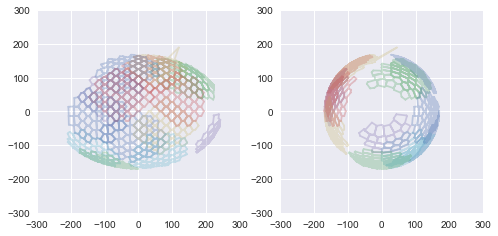

In [33]:
fig, axes = plt.subplots(1, 2)

for eptm in eptms:
    quick_edge_draw(eptm, ax=axes[0], coords=['z', 'y'], alpha=0.3)
    quick_edge_draw(eptm, ax=axes[1], coords=['x', 'y'], alpha=0.3)

axes[0].set(xlim=(-300, 300),
            ylim=(-300, 300),
            aspect='equal')
axes[1].set(xlim=(-300, 300),
            ylim=(-300, 300),
            aspect='equal')

In [34]:
dsets = merge_eptms(eptms)

In [39]:
dsets['face'] = dsets['face'].groupby('id').mean()

In [51]:
dsets['edge'].groupby('srce')['face_id'].apply(frozenset).drop_duplicates()

srce
0       (409, 410, 372)
1       (409, 410, 447)
2       (408, 409, 371)
3       (409, 371, 372)
4       (522, 523, 485)
5       (522, 484, 485)
6                 (596)
7       (524, 525, 487)
8       (561, 523, 524)
9       (448, 449, 487)
10      (448, 410, 447)
11      (410, 372, 373)
12      (336, 372, 373)
13      (297, 298, 334)
14                (297)
15           (596, 559)
17                (559)
18      (408, 370, 371)
19      (370, 371, 334)
20      (408, 370, 407)
21           (370, 407)
22           (264, 300)
23                (264)
24      (336, 299, 300)
25      (264, 299, 300)
26                (228)
27           (264, 228)
28      (484, 485, 446)
29      (485, 446, 447)
30      (409, 446, 447)
             ...       
1533    (720, 721, 687)
1534              (654)
1535         (618, 654)
1536              (618)
1538         (617, 618)
1540         (617, 581)
1541    (616, 617, 653)
1542    (616, 617, 581)
1543    (616, 580, 581)
1544         (580, 581)
1546    (72

In [40]:
dsets['edge']

,srce,face,dx,trgt,length,nz,dy,ny,nx,dz,face_z,face_id,opposite,opp_face_id,sub_area,sub_vol
edge,,,,,,,,,,,,,,,,
0,16,45,1.183658,15,8.589610,15.772323,-0.547276,-65.299704,82.938421,-8.490043,-10.881440,596,-1,595.0,53.365718,3431.316910
1,15,41,-15.263283,17,25.406095,39.657422,-19.943750,-130.158697,160.093487,-3.840401,-12.160553,559,-1,595.0,105.052275,5862.768536
2,6,45,-8.145185,16,18.854526,19.798383,-12.075076,-120.945626,150.198026,-11.972537,-10.881440,596,-1,632.0,96.926863,7392.678437
3,27,4,0.121534,23,3.724165,2.702581,2.211342,-6.422486,50.278495,2.994095,-7.599471,264,-1,229.0,25.379516,-2445.221323
4,26,1,3.324500,27,10.506694,-61.239582,-1.677359,-56.456608,152.492882,9.824702,-10.861458,228,-1,229.0,86.878815,-9224.007015
5,0,16,-2.290915,3,4.888280,-14.322131,-1.690246,-36.446604,51.732671,-3.973670,-0.284934,372,6,409.0,32.441284,-875.494669
6,3,21,2.290915,0,4.888280,-9.966671,1.690246,-42.002459,48.277107,3.973670,-2.220232,409,5,372.0,32.381399,-1002.551561
7,0,21,0.167763,1,8.847199,-2.576841,-0.132292,-64.771881,84.776438,8.844619,-2.220232,409,8,410.0,53.359819,-1440.024285
8,1,22,-0.167763,0,8.847199,-3.359442,0.132292,-67.145166,124.164345,-8.844619,0.000000,410,7,409.0,70.598413,-1280.827065


In [ ]:
dsets['edge'].groupy('srce')[]

In [64]:
quick_edge_draw(cc_eptm, ax=ax, coords=['z', 'y'], alpha=0.3)


ValueError: Length mismatch: Expected axis has 28691 elements, new values have 27732 elements

> /home/guillaume/miniconda3/envs/tyssue/lib/python3.5/site-packages/pandas/core/internals.py(2802)set_axis()
   2800             raise ValueError('Length mismatch: Expected axis has %d elements, '
   2801                              'new values have %d elements' %
-> 2802                              (old_len, new_len))
   2803 
   2804         self.axes[axis] = new_labels

ipdb> c


In [42]:
render, scene = view_3js(cc_eptm)

render

ValueError: Length mismatch: Expected axis has 133904 elements, new values have 125371 elements

> /home/guillaume/miniconda3/envs/tyssue/lib/python3.5/site-packages/pandas/core/internals.py(2802)set_axis()
   2800             raise ValueError('Length mismatch: Expected axis has %d elements, '
   2801                              'new values have %d elements' %
-> 2802                              (old_len, new_len))
   2803 
   2804         self.axes[axis] = new_labels

ipdb> c


In [193]:

cc_dsets = {'vert': pd.concat([eptm.vert_df
                               for eptm in eptms]),
            'face': pd.concat([eptm.face_df
                               for eptm in eptms]),
            'edge': pd.concat([eptm.edge_df
                               for eptm in eptms]),}

cc_eptm = Epithelium('cc', cc_dsets,
                     config.geometry.spherical_sheet())
fi_dsets = index_by_fid(cc_eptm)
fi_eptm = Epithelium('cc', fi_dsets,
                     config.geometry.spherical_sheet())



/home/guillaume/miniconda3/envs/tyssue/lib/python3.5/site-packages/tyssue-0.2rc1-py3.5.egg/tyssue/core/objects.py:752: PerformanceWarning: indexing past lexsort depth may impact performance.
  opposite = st_indexed.loc[flipped, 'edge'].values


ValueError: Length of values does not match length of index

> /home/guillaume/miniconda3/envs/tyssue/lib/python3.5/site-packages/pandas/core/series.py(2800)_sanitize_index()
   2798 
   2799     if len(data) != len(index):
-> 2800         raise ValueError('Length of values does not match length of ' 'index')
   2801 
   2802     if isinstance(data, PeriodIndex):

ipdb> c


In [88]:
pbc_thetas = np.concatenate([thetas + shift for shift in theta_shifts.ravel()])
pbc_phis = np.concatenate([phis + shift for shift in phi_shifts.ravel()])
pbc_voro = Voronoi(np.vstack([pbc_thetas, pbc_phis]).T)

pbc_dsets = from_2d_voronoi(pbc_voro)

pbc_dsets['face']['f_ids'] = np.concatenate([np.arange(phis.size),]* phi_shifts.size)


pbc_eptm = Epithelium('theta_phi', pbc_dsets, config.geometry.flat_sheet())

from tyssue import PlanarGeometry
pbc_eptm.sanitize()

PlanarGeometry.update_all(pbc_eptm)

pbc_eptm.edge_df['sx'] = pbc_eptm.upcast_srce(pbc_eptm.vert_df['x'])
pbc_eptm.edge_df['sy'] = pbc_eptm.upcast_srce(pbc_eptm.vert_df['y'])

border = ((pbc_eptm.edge_df['sx'] < -1.8*np.pi) |
          (pbc_eptm.edge_df['sx'] > 1.8*np.pi) |
          (pbc_eptm.edge_df['sy'] < -1.8*np.pi) |
          (pbc_eptm.edge_df['sy'] > 1.8*np.pi))

to_remove = pbc_eptm.edge_df[border].index
pbc_eptm.remove(to_remove)

In [90]:
from tyssue.core.objects import get_opposite

In [91]:
a, b, c = 170, 170, 250

In [92]:
pbc_eptm.vert_df['theta'] = pbc_eptm.vert_df['x']
pbc_eptm.vert_df['phi'] = pbc_eptm.vert_df['y']
pbc_eptm.vert_df['x'] = a * (np.cos(pbc_eptm.vert_df['theta']) *
                             np.cos(pbc_eptm.vert_df['phi']))
pbc_eptm.vert_df['y'] = b * (np.cos(pbc_eptm.vert_df['theta']) * 
                             np.sin(pbc_eptm.vert_df['phi']))
pbc_eptm.vert_df['z'] = c * np.sin(pbc_eptm.vert_df['theta'])



In [94]:
SheetGeometry.update_all(pbc_eptm)

In [95]:
render, scene = view_3js(pbc_eptm)

render

In [100]:
from tyssue import SheetGeometry
SheetGeometry.update_all(eptm)

In [101]:
to_remove = eptm.edge_df[(eptm.edge_df.srce==-1) |
                         (eptm.edge_df.trgt==-1)].index
#eptm.remove(to_remove)

In [102]:
eptm.vert_df = eptm.vert_df.drop(-1)
eptm.edge_df = eptm.edge_df.loc[eptm.edge_df.index.delete(to_remove)]


In [103]:
from tyssue.topology.base_topology import close_face

In [104]:
close_face(eptm, face)

In [105]:
render, scene = view_3js(eptm)

render

In [106]:
from tyssue.dynamics import SheetModel
from tyssue.solvers.sheet_vertex_solver import Solver

In [107]:
from tyssue.utils import scaled_unscaled
dyn_specs = config.dynamics.quasistatic_sheet_spec()
dyn_specs['vert']['basal_shift'] = 150

dyn_specs['face']['prefered_vol'] = 120
dyn_specs['face']['contractility'] = 1.
dyn_specs['edge']['line_tension'] = 4.


eptm.update_specs(dyn_specs, reset=True)
SheetGeometry.update_all(eptm)

Reseting datasets values with new specs


In [108]:
scales = np.linspace(0.1, 1., 30)
nrjs = [scaled_unscaled(SheetModel.compute_energy,
                        scale, eptm, SheetGeometry, args=(eptm,))
        for scale in scales]

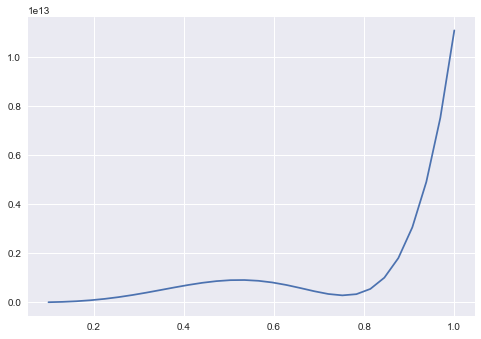

In [109]:
fig, ax = plt.subplots()
ax.plot(scales, nrjs)

In [110]:
SheetGeometry.scale(eptm, scales[np.argmin(nrjs[15:])+15], eptm.coords)

In [112]:
render, scene = view_3js(eptm)

render
